In [215]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import col

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import decomposition

athlete_df_path = './ALL-ATHLETES.csv'
movie_path = "./movies.csv"

1. What is the difference between SparkContext and SparkSession?

Prior to Spark 2.0, SparkContext was used to be a channel to access all Spark functionalities. Spark driver programes use SparkContext to connect the cluster, and create RDDs, accumulators and broadcast variables on that cluster. Also, there are several SparkContexts, such as SQLContext. If we want to use them, we need to create SQLContext respectively.

SparkSession is a new entry point of Spark with the Dataset and DataFrame API. We just need to create a SparkSession, and then we can use the SparkSession to manipulate the data, such as query the data from a dataframe.

2. Explain the shufﬂe operation in Spark operations. Give an example.

There are partitions in RDD. When some kind of spark operations, such as join, groupByKey, or repartition, raise, the spark redistributes data to different groups or keys. It calls shuffle. For instance, if we want to repartition a dataframe by the a column, Spark will find all values of keys of the dataframe, and separate data into different partitions by the column.

In [4]:
part1_q2_ex_df = spark.createDataFrame([10,11,13], "integer").toDF("age")
print("Before repartition: ")
print(part1_q2_ex_df.rdd.getNumPartitions())

repart_df = part1_q2_ex_df.repartition(2)
print("After repartition: ")
print(repart_df.rdd.getNumPartitions())

Before repartition: 
4
After repartition: 
2


3. What is the difference between a Spark transformation and a Spark action.

When we use a spark transformation, we will produce a new RDD from existing RDD. 
If we use a saprk action, we will get non-RDD values, which are stored to the external storage system or dirver.

Transformation : union()
            Action: count()

4. Cleaning Data

    a. What operations do we have on Panda DataFrames to deal with missing values?

    b. What are some of the problems that occur in dealing with missing values in Panda DataFrames?

    c. What operations do we have on Spark DataFrames to deal with missing values.

a. Panda DataFrames provides powerful funcions to deal with missing value such as isna(), notna(), notnull(), isnull(), and dropna(). isna(), notna(), notnull(), and isnull() will return list of boolean values which using index to indicate the result. Using the boolean list can revise missing values. For instance, 

"dropna()" can drop rows which contain missing values. Moreover, "dropna()" is able to set parameters to determine how to drop. For example, doprna(axis='columns') means drop every column which contains missing values.

b. A dataframe may have some of columns which contain NaN or None. If we use "dropna()" without setting parameters, then we will drop the rows which are correct. Furthermore, sometimes missing values are not NaN or None. Using string to describe like few spaces, "none", or "empty". Since "dropna()" function is only able to detect NaN or None, a string which indicate none or nan cannot be detected. In this situation, after dropna() function, the missing values still exist.

c. Spark provides DataFrameNaFunctions which is in pyspark.sql.DataFrameNaFunctions. For example, na.drop(): return a dataframe which omits rows with null. na.fill(value): fill cells with the value.

5. What is a categorical variable? Give an example.

Categorical variable is a variable which contains names or labels to represent a category. Also, the categories must be a fixed or limited values. 
Example:
1. sexed in the class: Male and Female.
2. Programs which SDSU offers: 95 bachelor's, 78 masters and 22 doctoral degree programs.

6. What are hyperparameters? Give an example.

Hyperparameters are parameters which are setted before training. Every model has its hyperparameters. Hyperparameters may change the result after training or clustering.
Example:
n_clusters of KMeans  : Use a integer to set. A labels of data will cluster into the number which is setted.
eps of DBSCAN         : A programmer can determine the distance between two samples.

# Part Two: 
This part uses the athlete data set in the ﬁle ALL-ATHLETES.csv. This dataset contains information about athletes that participated in the London 2012 Olympics. 

1. The data requires some cleaning. Make sure that you clean the data before working on the rest of the problems. All solutions should start with the original dataset.

In [7]:
all_athletes_df = pd.read_csv(athlete_df_path)
all_athletes_df = all_athletes_df.drop(columns=['Name','Date of birth', 'Place of birth','Event'])

2. Produce a scatter plot of the athletes weight verses height.

Text(0, 0.5, 'height')

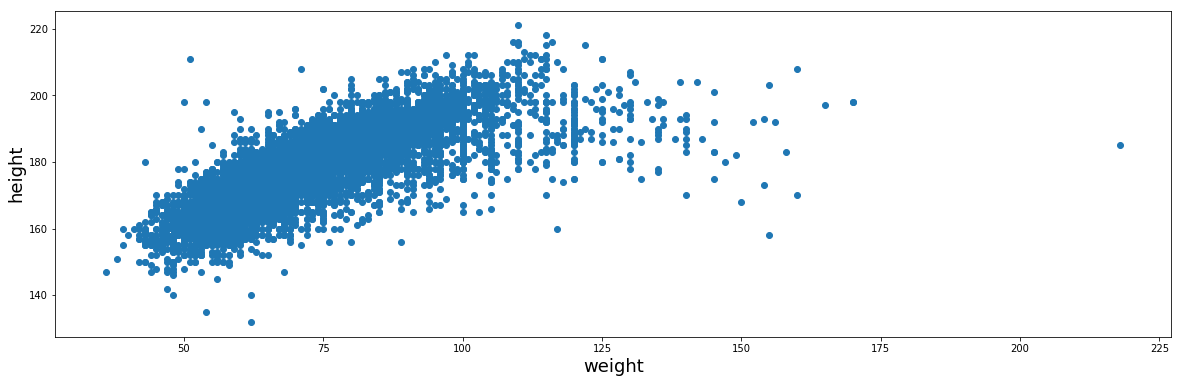

In [8]:
athlete_with_height_weight_df = all_athletes_df.dropna(subset=['Weight', 'Height, cm'])
plot_x_weigth = athlete_with_height_weight_df['Weight']
plot_y_height = athlete_with_height_weight_df['Height, cm']

plt.figure(figsize=(20,6)) 
ax = plt.scatter(plot_x_weigth, plot_y_height); 
plt.xlabel('weight', fontsize = 18)
plt.ylabel('height', fontsize = 18)

3. Produce box plots of the following. How do the weights compare?
    a. Female weights
    b. Male weights
    c. Weight of the male metal winners
    d. Weight of the female metal winners

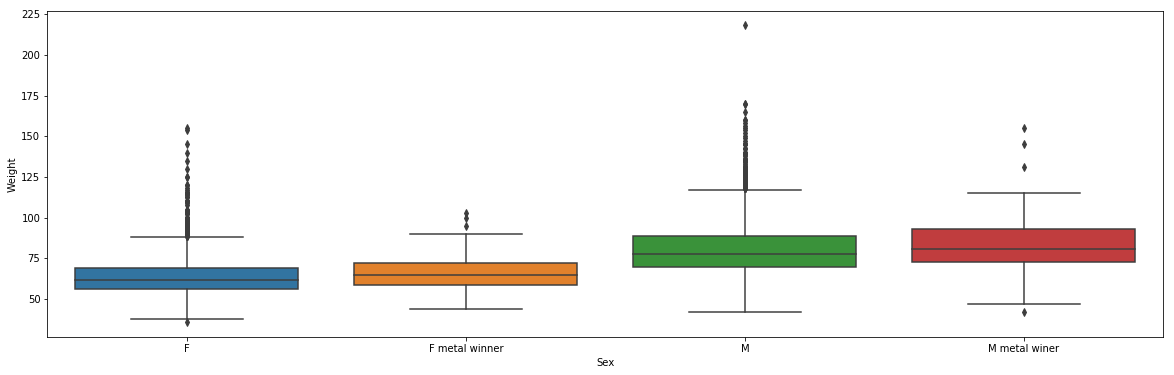

In [13]:
athlete_with_weight_df = all_athletes_df.dropna(subset=['Weight'])

athlete_won_metal = athlete_with_weight_df.loc[athlete_with_weight_df["Total"] !=0]
athlete_won_metal = athlete_won_metal.replace("F","F metal winner")
athlete_won_metal = athlete_won_metal.replace("M","M metal winer")

all_df_for_box = pd.concat([athlete_won_metal,athlete_with_weight_df]).sort_values('Sex')

plt.figure(figsize=(20,6))
sns.boxplot(x="Sex", y="Weight",data= all_df_for_box, orient='v')

4. Produce separate swarm plots of the ages of male metal winners and the female metal winners. How do the weights compare?

Text(0.5, 1.0, 'Female metal winner')

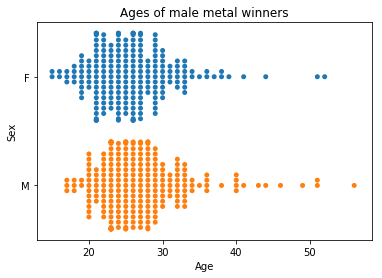

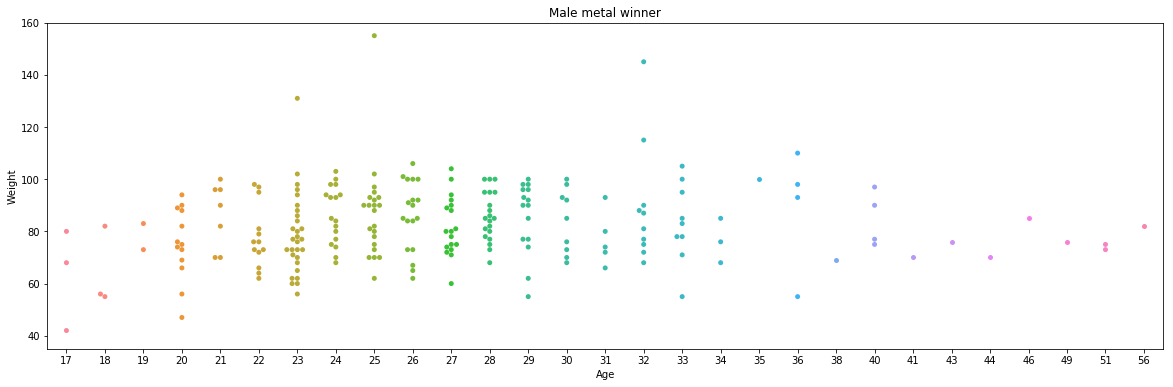

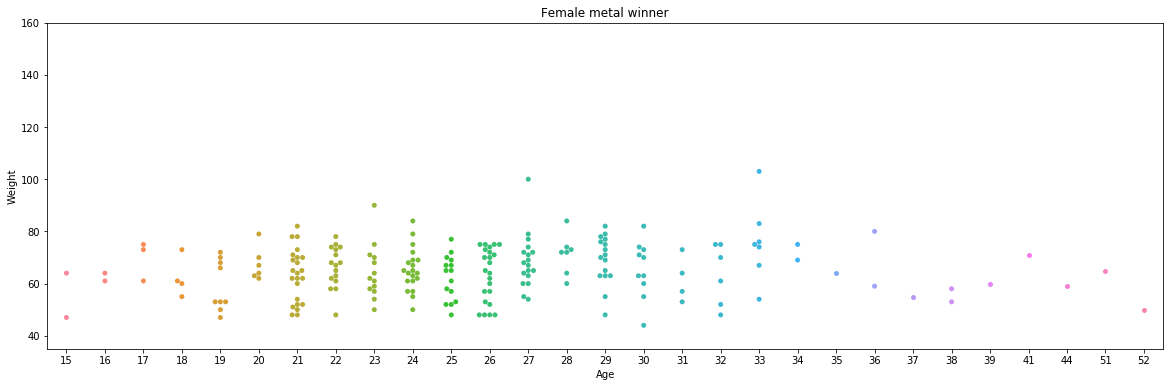

In [220]:
athlete_with_weight_df = all_athletes_df.dropna(subset=['Weight'])
athlete_won_metal = athlete_with_height_weight_df.loc[athlete_with_height_weight_df["Total"] !=0]

male_athlete_won_metal = athlete_won_metal.loc[athlete_won_metal['Sex'].isin(['M'])]
female_athlete_won_metal = athlete_won_metal.loc[athlete_won_metal['Sex'].isin(['F'])]


sns.swarmplot(x="Age", y="Sex",data= athlete_won_metal).set_title("Ages of male metal winners")


plt.figure(figsize=(20,6))
plt.ylim(35, 160)
sns.swarmplot(x="Age", y="Weight",data= male_athlete_won_metal).set_title("Male metal winner")

plt.figure(figsize=(20,6))
plt.ylim(35, 160)
sns.swarmplot(x="Age", y="Weight",data= female_athlete_won_metal).set_title("Female metal winner")

Weight of males is about 10 heavier than female. Also, the weights of metal winners are similar, although their ages are different.If they are female, their weights are around 60. If they are male, their weights are around 80.

5. Produce separate violin plots for the ages of the athletes in Archery, Sailing, and Swimming. How do the ages compare?

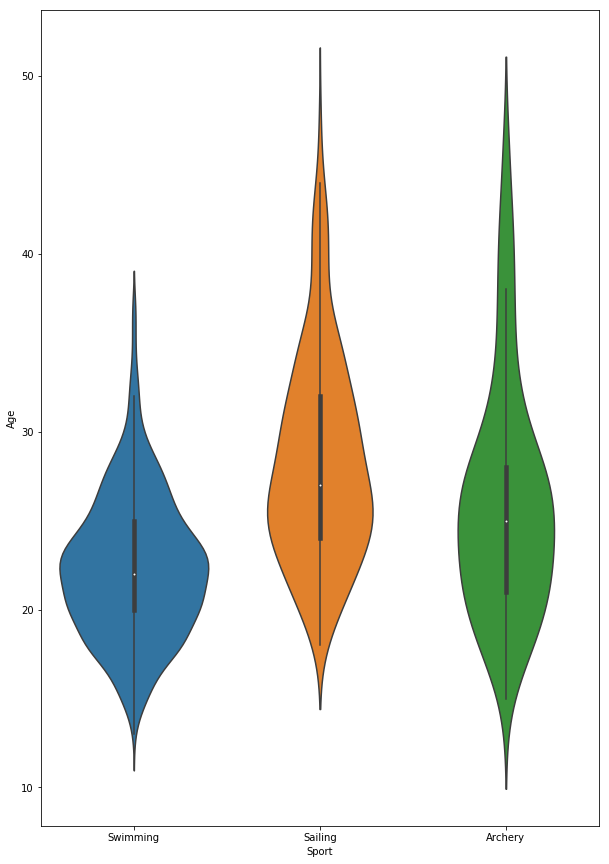

In [15]:
athlete_age_sport_df = all_athletes_df.dropna(subset=['Age','Sport'])
athlete_age_sport_df = athlete_age_sport_df.loc[(athlete_age_sport_df["Sport"] == 'Archery') | (athlete_age_sport_df["Sport"] == 'Sailing') | (athlete_age_sport_df["Sport"] == 'Swimming')]
# athlete_won_metal

plt.figure(figsize=(10,15))
# plt.ylim(35, 160)
sns.violinplot(x="Sport", y="Age",data= athlete_age_sport_df)


The moust of athletes in sailing whose ages are higher than the other sports. The range of ages of athletes in swimming are the narrowest of them. The Archery is widest. Archery has 10 to 50 years old athletes.  

6. Produce a histogram of the metals won per country, sorted by the number of metals won.

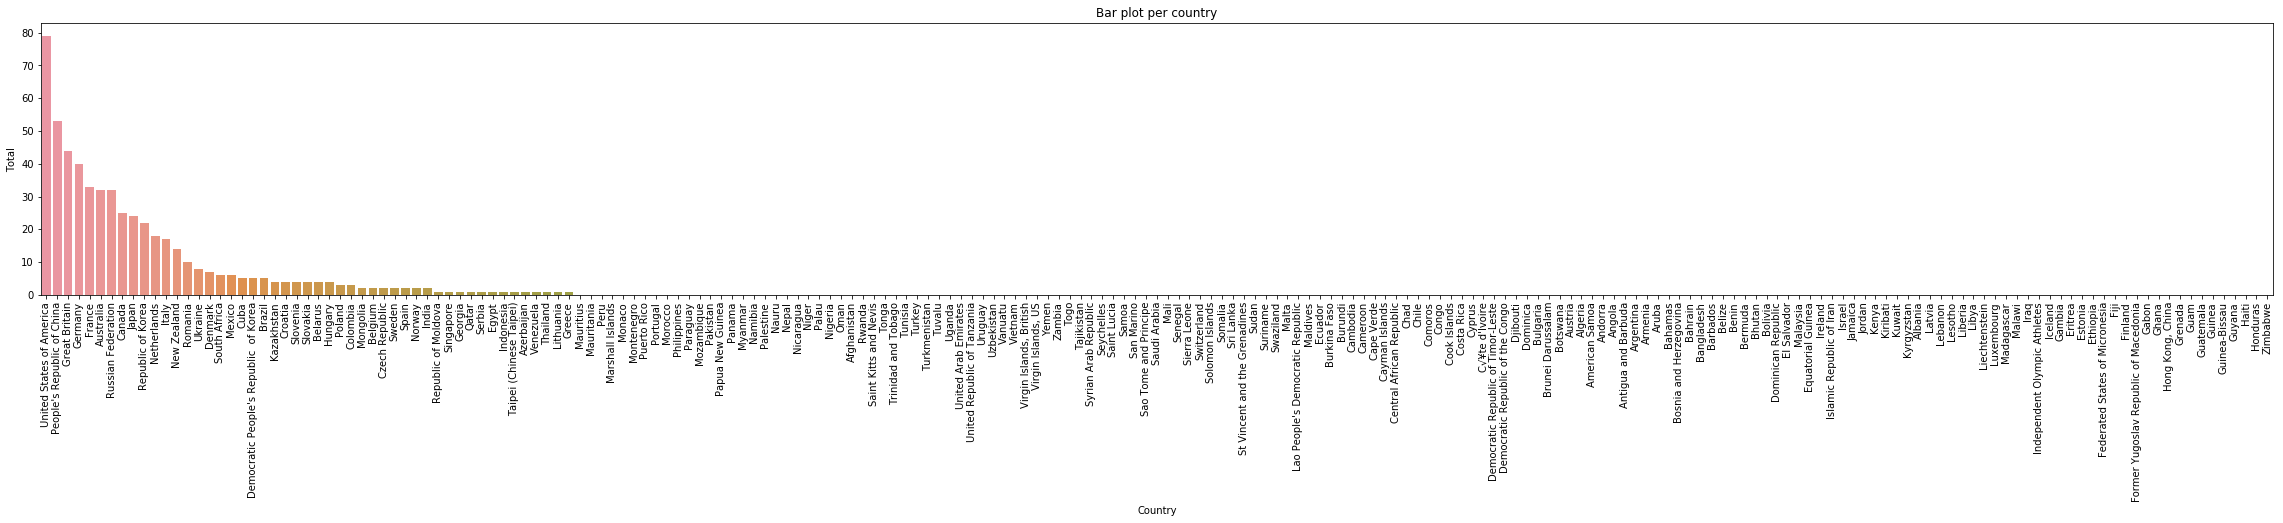

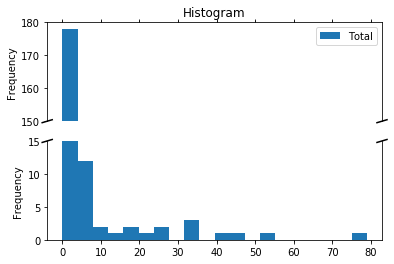

In [31]:
athlete_country_df = all_athletes_df.dropna(subset=['Country'])

athlete_country_df= athlete_country_df[["Country","Total"]].groupby("Country").sum().reset_index()
athlete_country_df = athlete_country_df.sort_values(by=['Total'], ascending =False)

plt.figure(figsize=(40,5))
bar_plot = sns.barplot(x="Country", y="Total", data=athlete_country_df)
bar_plot.set_title("Bar plot per country")
_ = bar_plot.set_xticklabels(labels=bar_plot.get_xticklabels(), rotation=90)

_, (ax, ax2) = plt.subplots(2, 1, sharex=True)
athlete_country_df.plot.hist(bins=20, ax=ax, ylim=[150,180])
athlete_country_df.plot.hist(bins=20, ax=ax2,  ylim=[0,15],legend = False)
ax.set_title('Histogram')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.xaxis.tick_top()
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Part Three: 
This part uses the movie dataset in the movies.csv ﬁle. The data set classiﬁes the movies as either a romance or an action movie. The columns other than "Title", "Genre", "Year", "Rating", "# Votes" and "# Words" in the ﬁle are all words that appear in some of the movies in our dataset. The words are stemmed. The column for a word shows the percentage of the total words in the movie were that particular word. So for example the word “the” was 0.043807463 percent of the words that were spoken in the movie “The Terminator”.

1. Using scikit-learn split the movie data into a training and test set. Create three different models from the training set to classify movies as action or romance using K-means, DBSCAN and GaussianNB.

In [18]:
all_movies_df = pd.read_csv(movie_path)
all_movies_df = all_movies_df.drop(columns=["Rating","Title","Year", "# Votes", "# Words"])

columns_names = all_movies_df.columns
columns_without_genre = columns_names.drop( ["Genre"])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_movies_df[columns_without_genre], all_movies_df["Genre"], test_size=0.2,random_state=34)

In [116]:
#K-means
label_action = 0
label_romance = 0

kmeans = KMeans(n_clusters = 2,random_state = 1).fit(X_train)

romance_0 = 0
romance_1 = 0

ind = 0
for label in y_train:
    if label == "romance":
        if kmeans.labels_[ind] ==0:
            romance_0 += 1
        else:
            romance_1 += 1
    ind += 1

if romance_1 > romance_0:
    label_romance = 1
    label_action = 0
else:
    label_romance = 0
    label_action = 1
    
kmean_y_predict = kmeans.predict(X_test)

mean_y_test_label = y_test.replace("romance", label_romance)
mean_y_test_label = mean_y_test_label.replace("action", label_action)


kmean_accuracy = metrics.accuracy_score(mean_y_test_label,kmean_y_predict)
print("K-Means Accuracy:  ", kmean_accuracy)

K-Means Accuracy:   0.7959183673469388


In [115]:
# DASCAN
dbscan = DBSCAN(eps=0.05, min_samples=10).fit(X_test)

# dbscan_y_test_label = y_train.replace("romance", 0)
dbscan_y_test_label = y_test.replace("romance", 0)
dbscan_y_test_label = dbscan_y_test_label.replace("action", 1)
dbscan_y_test_label = dbscan_y_test_label.reset_index()
dbscan_y_test_label = dbscan_y_test_label.drop(columns=["index"])

y_predict = dbscan.labels_
remove_ind = []
dbscan_y_predict = []
for ind in range(y_predict.size):
    if(y_predict[ind] == -1):
        remove_ind.append(ind)
    else:
        dbscan_y_predict.append(y_predict[ind])

dbscan_y_test_label = dbscan_y_test_label.drop(index = remove_ind)
dbscan_y_test_label = dbscan_y_test_label.values.reshape(-1)
dbscan_accuracy = metrics.accuracy_score(dbscan_y_test_label,dbscan_y_predict)

print("DBSCAN Accuracy:  ", dbscan_accuracy)

DBSCAN Accuracy:   0.3958333333333333


In [138]:
#GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
gnb_y_predict = clf.predict(X_test)

# gaussiannb_accuracy = clf.score(X_test,y_test)
gaussiannb_accuracy = metrics.accuracy_score(y_test,gnb_y_predict)
print("GaussianNB Accuracy:  ", gaussiannb_accuracy)

GaussianNB Accuracy:   0.5714285714285714


2. Compare the performance of the three classiﬁers using accuracy score and confusion matrix. Which classiﬁer is better? Why?

In [114]:
# confusion_matrix
kmean_cm = metrics.confusion_matrix(mean_y_test_label,kmean_y_predict)
print("K-Means CM          Accuracy")
print(kmean_cm, "          " , kmean_accuracy, end="\n\n")

# dbscan_cm = metrics.confusion_matrix(dbscan_y_test_label,dbscan_y_predict)
dbscan_cm = metrics.confusion_matrix(dbscan_y_test_label,dbscan_y_predict)
print("DBSCAN CM          Accuracy")
print(dbscan_cm, "          ",dbscan_accuracy, end="\n\n")

gnb_cm = metrics.confusion_matrix(y_test,gnb_y_predict)
print("GaussianNB CM          Accuracy")
print(gnb_cm, "          ",gaussiannb_accuracy , end="\n\n")

K-Means CM          Accuracy
[[25  4]
 [ 6 14]]            0.7959183673469388

DBSCAN CM          Accuracy
[[19  0]
 [29  0]]            0.3958333333333333

GaussianNB CM          Accuracy
[[20  9]
 [12  8]]            0.5714285714285714



According to the confusion matrices and accuracies, K-Means is the better than the others. Although, an accuracy of K-Means are not stable, the accuracy can up to 80%. Even the lowest accuracy is around 40%, but the others are around 40~50%. It means the worst case of K-means is just similar to the others.  
In my code, I set the random_state as 1 to make sure the result will be the same.

3. Compare two cluster results using Adjusted Rand index, Homogeneity, completeness and V-measure and Silhouette Coefﬁcient. 

In [131]:
#K-Means Classifier
# 1. Adjusted Rand index
kmean_ari = metrics.adjusted_rand_score(mean_y_test_label,kmean_y_predict)

# 2. Homogeneity, completeness, and V-measure
kmean_homo,kmean_complete,kmean_vmeasure = metrics.homogeneity_completeness_v_measure(mean_y_test_label,kmean_y_predict)

# 3. Silhouette Coefficient 
kmean_silhouette = metrics.silhouette_score(X_test,kmean_y_predict)

print("ARI                : ", kmean_ari)
print("Homogeneity score  : ", kmean_homo)
print("Completeness score : ", kmean_complete)
print("V-measure score    : ", kmean_vmeasure)
print("Silhouette score   : ", kmean_silhouette)

ARI                :  0.33627396499027506
Homogeneity score  :  0.25253116653523533
Completeness score :  0.25969563451236205
V-measure score    :  0.25606329615470835
Silhouette score   :  0.06104041438014608


In [193]:
#DBSCN Classifier
# 1. Adjusted Rand index
dbscan_ari = metrics.adjusted_rand_score(dbscan_y_test_label,dbscan_y_predict)

# 2. Homogeneity, completeness, and V-measure
dbscan_homo,dbscan_complete,dbscan_vmeasure = metrics.homogeneity_completeness_v_measure(dbscan_y_test_label,dbscan_y_predict)

# 3. Silhouette Coefficient 
dbscan_silhouette = metrics.silhouette_score(X_test,dbscan.labels_)

print("ARI                : ", dbscan_ari)
print("Homogeneity score  : ", dbscan_homo)
print("Completeness score : ", dbscan_complete)
print("V-measure score    : ", dbscan_vmeasure)
print("Silhouette score   : ", dbscan_silhouette)

ARI                :  0.0
Homogeneity score  :  2.48081219184755e-16
Completeness score :  1.0
V-measure score    :  4.961624383695099e-16
Silhouette score   :  0.3754869302054127


In [192]:
#GaussianNB Classifier
# 1. Adjusted Rand index
gnb_ari = metrics.adjusted_rand_score(y_test,gnb_y_predict)

# 2. Homogeneity, completeness, and V-measure
gnb_homo,gnb_complete,gnb_vmeasure = metrics.homogeneity_completeness_v_measure(y_test,gnb_y_predict)

# 3. Silhouette Coefficient 
gnb_silhouette = metrics.silhouette_score(X_test,gnb_y_predict)

print("ARI                : ", gnb_ari)
print("Homogeneity score  : ", gnb_homo)
print("Completeness score : ", gnb_complete)
print("V-measure score    : ", gnb_vmeasure)
print("Silhouette score   : ", gnb_silhouette)

ARI                :  -0.0010191318849307072
Homogeneity score  :  0.006304087009585887
Completeness score :  0.006603427067985791
V-measure score    :  0.006450286019113718
Silhouette score   :  0.014622805258407414


ARI:
ARI shows that two ways to cluster the dataset are both not strong enough to cluster or predict the result, since scores are low. The scrore of K-Means is around 0.3~0.4, the score of GaussianNB is around -0.001, and the score of DBSCAN is 0.
Having low scores with the same dataset in three classifiers tells us the dataset is not good enough to be a data to train or cluster.

Homogeneity:
Homogeneity score tells us that a cluster of prediction maps to differnt values a lot. It means that there isn't much difference between each movie. Therefore, the two different types of movies are high probability to cluster or predict to the same types. Although, we can figure out that K-Means is the best, the score is still low. Consequently, the result shows the movies of the dataset doesn't contain obvious attributes between each other.

Completeness:
Completeness is similar to homogeneity, but it's opposite to homogenity. The low score means that two same type of movies are high probability to cluster or predict to different types. The score of DBSCAN is 1, because it only one cluster, excluding noise. Therefore, DBSCAN indeed has perfect completeness, but it cannot determine DBSCAN is the best. The conclusion is the same as homogeneity, we need more data or  more information which has more difference between each movie to improve.  

V-measure: 
The V-measure is the harmonic mean between homogeneity and completeness. The conclusion is similiar with both of them. Dataset needs more information.

Silhouette:
Low silhouette score expresses that clusters overlap a lot. In ours situation, no matter what classifier we used, the score is low. It means the movies in our dataset are not very different from each other. the result is consistent in result of other scores. 

4. The movie dataset has a lot of features. Use PCA to reduce the dataset to 30 independent variables. Repeat 1-3 on the reduced dataset. (PCA - Principle Component Analysis)

In [203]:
pca = decomposition.PCA(n_components=30)
principalComponents = pca.fit_transform(all_movies_df[columns_without_genre])
principalDf = pd.DataFrame(data = principalComponents)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = sklearn.model_selection.train_test_split(principalDf, all_movies_df["Genre"], test_size=0.2,random_state=34)

# 4.1.Create three different models from the training set to classify movies as action or romance using K-means, DBSCAN and GaussianNB.

In [185]:
#K-means
label_action = 0
label_romance = 0

pca_kmeans = KMeans(n_clusters = 2,random_state = 8).fit(pca_X_train)

romance_0 = 0
romance_1 = 0

ind = 0
for label in pca_y_train:
    if label == "romance":
        if kmeans.labels_[ind] ==0:
            romance_0 += 1
        else:
            romance_1 += 1
    ind += 1

if romance_1 > romance_0:
    label_romance = 1
    label_action = 0
else:
    label_romance = 0
    label_action = 1
    
pca_kmean_y_predict = pca_kmeans.predict(pca_X_test)

pca_kmean_y_test_label = pca_y_test.replace("romance", label_romance)
pca_kmean_y_test_label = pca_kmean_y_test_label.replace("action", label_action)


kmean_accuracy = metrics.accuracy_score(pca_kmean_y_test_label,pca_kmean_y_predict)
print("K-Means Accuracy:  ", kmean_accuracy)


# 5 = 0.8367346938775511
# 6 = 0.5918367346938775
# 8 = 0.8163265306122449

K-Means Accuracy:   0.8163265306122449


In [189]:
#PCA DASCAN
pca_dbscan = DBSCAN(eps=0.05, min_samples=10).fit(X_test)

pca_dbscan_y_test_label = y_test.replace("romance", 0)
pca_dbscan_y_test_label = pca_dbscan_y_test_label.replace("action", 1)
pca_dbscan_y_test_label = pca_dbscan_y_test_label.reset_index()
pca_dbscan_y_test_label = pca_dbscan_y_test_label.drop(columns=["index"])

pca_y_predict = pca_dbscan.labels_
remove_ind = []
pca_dbscan_y_predict = []
for ind in range(pca_y_predict.size):
    if(pca_y_predict[ind] == -1):
        remove_ind.append(ind)
    else:
        pca_dbscan_y_predict.append(pca_y_predict[ind])

pca_dbscan_y_test_label = pca_dbscan_y_test_label.drop(index = remove_ind)
pca_dbscan_y_test_label = pca_dbscan_y_test_label.values.reshape(-1)
pca_dbscan_accuracy = metrics.accuracy_score(dbscan_y_test_label,pca_dbscan_y_predict)

print("DBSCAN Accuracy:  ", pca_dbscan_accuracy)

DBSCAN Accuracy:   0.3958333333333333


In [194]:
#GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
pca_gnb_y_predict = clf.predict(X_test)

# gaussiannb_accuracy = clf.score(X_test,y_test)
gaussiannb_accuracy = metrics.accuracy_score(y_test,pca_gnb_y_predict)
print("GaussianNB Accuracy:  ", gaussiannb_accuracy)

GaussianNB Accuracy:   0.5714285714285714


# 2. Compare the performance of the three classiﬁers using accuracy score and confusion matrix.

In [198]:
#K-Means Classifier
# 1. Adjusted Rand index
pca_kmean_ari = metrics.adjusted_rand_score(mean_y_test_label,pca_kmean_y_predict)

# 2. Homogeneity, completeness, and V-measure
pca_kmean_homo,pca_kmean_complete,pca_kmean_vmeasure = metrics.homogeneity_completeness_v_measure(mean_y_test_label,pca_kmean_y_predict)

# 3. Silhouette Coefficient 
pca_kmean_silhouette = metrics.silhouette_score(X_test,pca_kmean_y_predict)

print("ARI                : ", pca_kmean_ari)
print("Homogeneity score  : ", pca_kmean_homo)
print("Completeness score : ", pca_kmean_complete)
print("V-measure score    : ", pca_kmean_vmeasure)
print("Silhouette score   : ", pca_kmean_silhouette)

ARI                :  0.38750000000000007
Homogeneity score  :  0.29691644418777297
Completeness score :  0.3006737350474453
V-measure score    :  0.2987832778148932
Silhouette score   :  0.06533780756891579


In [197]:
#DBSCN Classifier
# 1. Adjusted Rand index
pca_dbscan_ari = metrics.adjusted_rand_score(pca_dbscan_y_test_label,pca_dbscan_y_predict)

# 2. Homogeneity, completeness, and V-measure
pca_dbscan_homo,pca_dbscan_complete,pca_dbscan_vmeasure = metrics.homogeneity_completeness_v_measure(pca_dbscan_y_test_label,pca_dbscan_y_predict)

# 3. Silhouette Coefficient 
pca_dbscan_silhouette = metrics.silhouette_score(X_test,dbscan.labels_)

print("ARI                : ", pca_dbscan_ari)
print("Homogeneity score  : ", pca_dbscan_homo)
print("Completeness score : ", pca_dbscan_complete)
print("V-measure score    : ", pca_dbscan_vmeasure)
print("Silhouette score   : ", pca_dbscan_silhouette)

ARI                :  0.0
Homogeneity score  :  2.48081219184755e-16
Completeness score :  1.0
V-measure score    :  4.961624383695099e-16
Silhouette score   :  0.3754869302054127


In [199]:
#GaussianNB Classifier
# 1. Adjusted Rand index
pca_gnb_ari = metrics.adjusted_rand_score(y_test,pca_gnb_y_predict)

# 2. Homogeneity, completeness, and V-measure
pca_gnb_homo,pca_gnb_complete,pca_gnb_vmeasure = metrics.homogeneity_completeness_v_measure(y_test,pca_gnb_y_predict)

# 3. Silhouette Coefficient 
pca_gnb_silhouette = metrics.silhouette_score(X_test,pca_gnb_y_predict)

print("ARI                : ", pca_gnb_ari)
print("Homogeneity score  : ", pca_gnb_homo)
print("Completeness score : ", pca_gnb_complete)
print("V-measure score    : ", pca_gnb_vmeasure)
print("Silhouette score   : ", pca_gnb_silhouette)

ARI                :  -0.0010191318849307072
Homogeneity score  :  0.006304087009585887
Completeness score :  0.006603427067985791
V-measure score    :  0.006450286019113718
Silhouette score   :  0.014622805258407414


a. How do the result compare using the reduced dataset

The result is musch similiar to the original dataset. The scores are a little bit different from original scores. Must of the values are the same.

b. How much of the variation of the original dataset is in the new 30 dimensions.

In [214]:
sum_ratio = sum(pca.explained_variance_ratio_)
print("Sum of explained variance: ", "{0:.2%}".format(sum_ratio))

Sum of explained variance:  71.56%


The new 30 dimensions contains 71.56% of the variance, but the result shows the accuracies or scores are similar to original dataset. Thus, we can reduce the number of features to train or predict. It can prevent from memory erro when there are too much features.